In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Mon Jun 27 00:15:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 27%   35C    P8    22W / 260W |   1243MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 25%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2012 = db.rm_patent_cn_2012
    db_rm_us_2012 = db.rm_patent_us_2012
    db_rm_de_2012 = db.rm_patent_de_2012

    
except errors.ConnectionFailure as err:
    print(err)

# 2012

## Company數量

In [6]:
data_assignee = db_rm_de_2012.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2012.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2012.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
# final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

### DE

In [11]:
# 取總數前15家公司
df_family_de.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
6,International Business Machines Corp,2
0,Giesecke and Devrient GmbH,1
1,GlobalFoundries Inc,1
2,GlobalFoundries US Inc,1
3,INNOVATIVE OBERFLAECHENTECHNOLOGIEN GmbH,1
4,ITK Engineering GmbH,1
5,Innovative Oberflachentechnologien GmbH,1
7,M2C Solutions GmbH,1
8,Merck Patent GmbH,1
9,Thomas Nickert Druckveredelung GmbH,1


In [12]:
com_de_df = df_family_de.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_de_df.reset_index(drop=True, inplace=True)

In [13]:
com_de_df["count_log"] = com_de_df["count"].apply(lambda x: np.log(x))
com_de_df

,company,count,count_log
0,International Business Machines Corp,2,0.693147
1,Giesecke and Devrient GmbH,1,0.000000
2,GlobalFoundries Inc,1,0.000000
3,GlobalFoundries US Inc,1,0.000000
4,INNOVATIVE OBERFLAECHENTECHNOLOGIEN GmbH,1,0.000000
5,ITK Engineering GmbH,1,0.000000
6,Innovative Oberflachentechnologien GmbH,1,0.000000
7,M2C Solutions GmbH,1,0.000000
8,Merck Patent GmbH,1,0.000000
9,Thomas Nickert Druckveredelung GmbH,1,0.000000


In [14]:
com_de_ls = list(com_de_df.company)

### CN

In [15]:
# 取總數前15家公司
df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
14,Jiangsu IoT Research and Development Center,100
18,Nanjing IoT Sensor Technology Co Ltd,52
7,China core Microelectronics Technology Chengdu...,25
17,NANJING AQUAPEL IOT CO Ltd,20
2,"BEIJING GOLDENET IOT TECHNOLOGY CO., LTD.",18
10,"Gaoxing Zhilian Technology Co., Ltd.",17
12,Institute of Microelectronics of CAS,13
27,XIAMEN XINDECO IOT TECHNOLOGY Ltd,12
13,Jiangsu CAS IGBT Technology Co Ltd,12
21,Seiko Epson Corp,10


In [16]:
com_cn_df = df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_cn_df.reset_index(drop=True, inplace=True)

In [17]:
com_cn_df["count_log"] = com_cn_df["count"].apply(lambda x: np.log(x))
com_cn_df

,company,count,count_log
0,Jiangsu IoT Research and Development Center,100,4.605170
1,Nanjing IoT Sensor Technology Co Ltd,52,3.951244
2,China core Microelectronics Technology Chengdu...,25,3.218876
3,NANJING AQUAPEL IOT CO Ltd,20,2.995732
4,"BEIJING GOLDENET IOT TECHNOLOGY CO., LTD.",18,2.890372
5,"Gaoxing Zhilian Technology Co., Ltd.",17,2.833213
6,Institute of Microelectronics of CAS,13,2.564949
7,XIAMEN XINDECO IOT TECHNOLOGY Ltd,12,2.484907
8,Jiangsu CAS IGBT Technology Co Ltd,12,2.484907
9,Seiko Epson Corp,10,2.302585


In [18]:
com_cn_ls = list(com_cn_df.company)

### US

In [19]:
# 取總數前15家公司
df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
2,Cisco Technology Inc,33
28,Xerox Corp,17
20,Qualcomm Inc,6
3,Electronics and Telecommunications Research In...,5
6,FutureWei Technologies Inc,5
18,Nokia Solutions and Networks Oy,5
15,LG Electronics Inc,4
12,International Business Machines Corp,4
22,Samsung Electronics Co Ltd,4
21,Roamware Inc,4


In [20]:
com_us_df = df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_us_df.reset_index(drop=True, inplace=True)

In [21]:
com_us_df["count_log"] = com_us_df["count"].apply(lambda x: np.log(x))
com_us_df

,company,count,count_log
0,Cisco Technology Inc,33,3.496508
1,Xerox Corp,17,2.833213
2,Qualcomm Inc,6,1.791759
3,Electronics and Telecommunications Research In...,5,1.609438
4,FutureWei Technologies Inc,5,1.609438
5,Nokia Solutions and Networks Oy,5,1.609438
6,LG Electronics Inc,4,1.386294
7,International Business Machines Corp,4,1.386294
8,Samsung Electronics Co Ltd,4,1.386294
9,Roamware Inc,4,1.386294


In [22]:
com_us_ls = list(com_us_df.company)

# Data

## CN

In [23]:
ccontry = pd.read_csv("../rm_company_country_cn_2012.csv")
ccpc = pd.read_csv("../rm_company_cpc_cn_2012.csv")

In [24]:
ccontry[ccontry.company.isin(com_cn_ls)]

,company,AR,AU,BR,CA,CL,CN,CY,DE,DK,...,PT,RS,RU,SE,SG,SI,TW,UA,US,ZA
3,ANHUI YONGDA IOT Co Ltd,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,BEIJING GOLDENET IOT TECHNOLOGY Co Ltd,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,Datang Mobile Communications Equipment Co Ltd,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
89,GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,GUANGZHOU WULIANJIA INFORMATION TECHNOLOGY Co Ltd,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,"Gaoxing Zhilian Technology Co., Ltd.",0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,Huawei Technologies Co Ltd,0.0,0.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
152,Institute of Microelectronics of CAS,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,Jiangsu CAS IGBT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,Jiangsu IoT Research and Development Center,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Similarity計算

#### Country

- 換成機率  

In [25]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

#### PBC
- 和Samsung Electronics Co Ltd比較

In [26]:
ccontry_pbc = ccontry2.loc[com_cn_ls,:].copy()
ccontry_pbc.head()

,AR,AU,BR,CA,CL,CN,CY,DE,DK,EA,...,PT,RS,RU,SE,SG,SI,TW,UA,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Nanjing IoT Sensor Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jiangsu IoT Research and Development Center,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Suzhou Hickman IOT Technology Co. Ltd.,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zhuhai Youte Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZTE Intelligent IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

KeyError: 'Samsung Electronics Co Ltd'

#### CPC

In [ ]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [ ]:
ccpc_pbc = ccpc2.loc[com_cn_ls,:].copy()
# ccpc_pbc

In [ ]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### Scatter Plot

In [ ]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_cn_df.count_log[com_cn_df.company=="Samsung Electronics Co Ltd"].values-com_cn_df.count_log[com_cn_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_cn_df.count_log[com_cn_df.company=="Samsung Electronics Co Ltd"].values-com_cn_df.count_log[com_cn_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

In [ ]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_2012_1.png'.format(pbc_n))

In [ ]:
c_df

In [ ]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_2012_2.png'.format(pbc_n))

In [ ]:
c_df

### Scatter Plot2

In [ ]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

In [ ]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [ ]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [ ]:
competitor_ls

In [ ]:
c_df

## US

In [23]:
ccontry = pd.read_csv("../rm_company_country_us_2012.csv")
ccpc = pd.read_csv("../rm_company_cpc_us_2012.csv")

In [24]:
ccontry[ccontry.company.isin(com_us_ls)]

,company,AR,AU,BR,CA,CN,DE,EP,ES,FI,...,KR,MX,MY,NL,PL,RU,SE,SG,TW,US
1,Alcatel Lucent SAS,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0
6,Cisco Technology Inc,0.0,0.0,0.0,6.0,1.0,0.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
8,Electronics and Telecommunications Research In...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
11,Fujifilm Business Innovation Corp,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
12,FutureWei Technologies Inc,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
19,INTERNATIONAL MOBILE IOT CORP,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0
24,International Business Machines Corp,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
26,KT Corp,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
30,LG Electronics Inc,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
39,Nokia Solutions and Networks Oy,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


### Similarity計算

#### Country

- 換成機率  

In [25]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

#### PBC
- 和Samsung Electronics Co Ltd比較

In [26]:
ccontry_pbc = ccontry2.loc[com_us_ls,:].copy()
ccontry_pbc.head()

,AR,AU,BR,CA,CN,DE,EP,ES,FI,FR,...,KR,MX,MY,NL,PL,RU,SE,SG,TW,US
company,,,,,,,,,,,,,,,,,,,,,
Cisco Technology Inc,0.0,0.0,0.0,0.109091,0.018182,0.0,0.272727,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.600000
Xerox Corp,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.894737
Qualcomm Inc,0.0,0.0,0.0,0.000000,0.125000,0.0,0.125000,0.0,0.0,0.0,...,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.375000
Electronics and Telecommunications Research Institute ETRI,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.3750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.625000
FutureWei Technologies Inc,0.0,0.0,0.0,0.000000,0.214286,0.0,0.142857,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.642857


In [27]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

#### CPC

In [28]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [29]:
ccpc_pbc = ccpc2.loc[com_us_ls,:].copy()
# ccpc_pbc

In [30]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### Scatter Plot

In [31]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_us_df.count_log[com_us_df.company=="Samsung Electronics Co Ltd"].values-com_us_df.count_log[com_us_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_us_df.count_log[com_us_df.company=="Samsung Electronics Co Ltd"].values-com_us_df.count_log[com_us_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

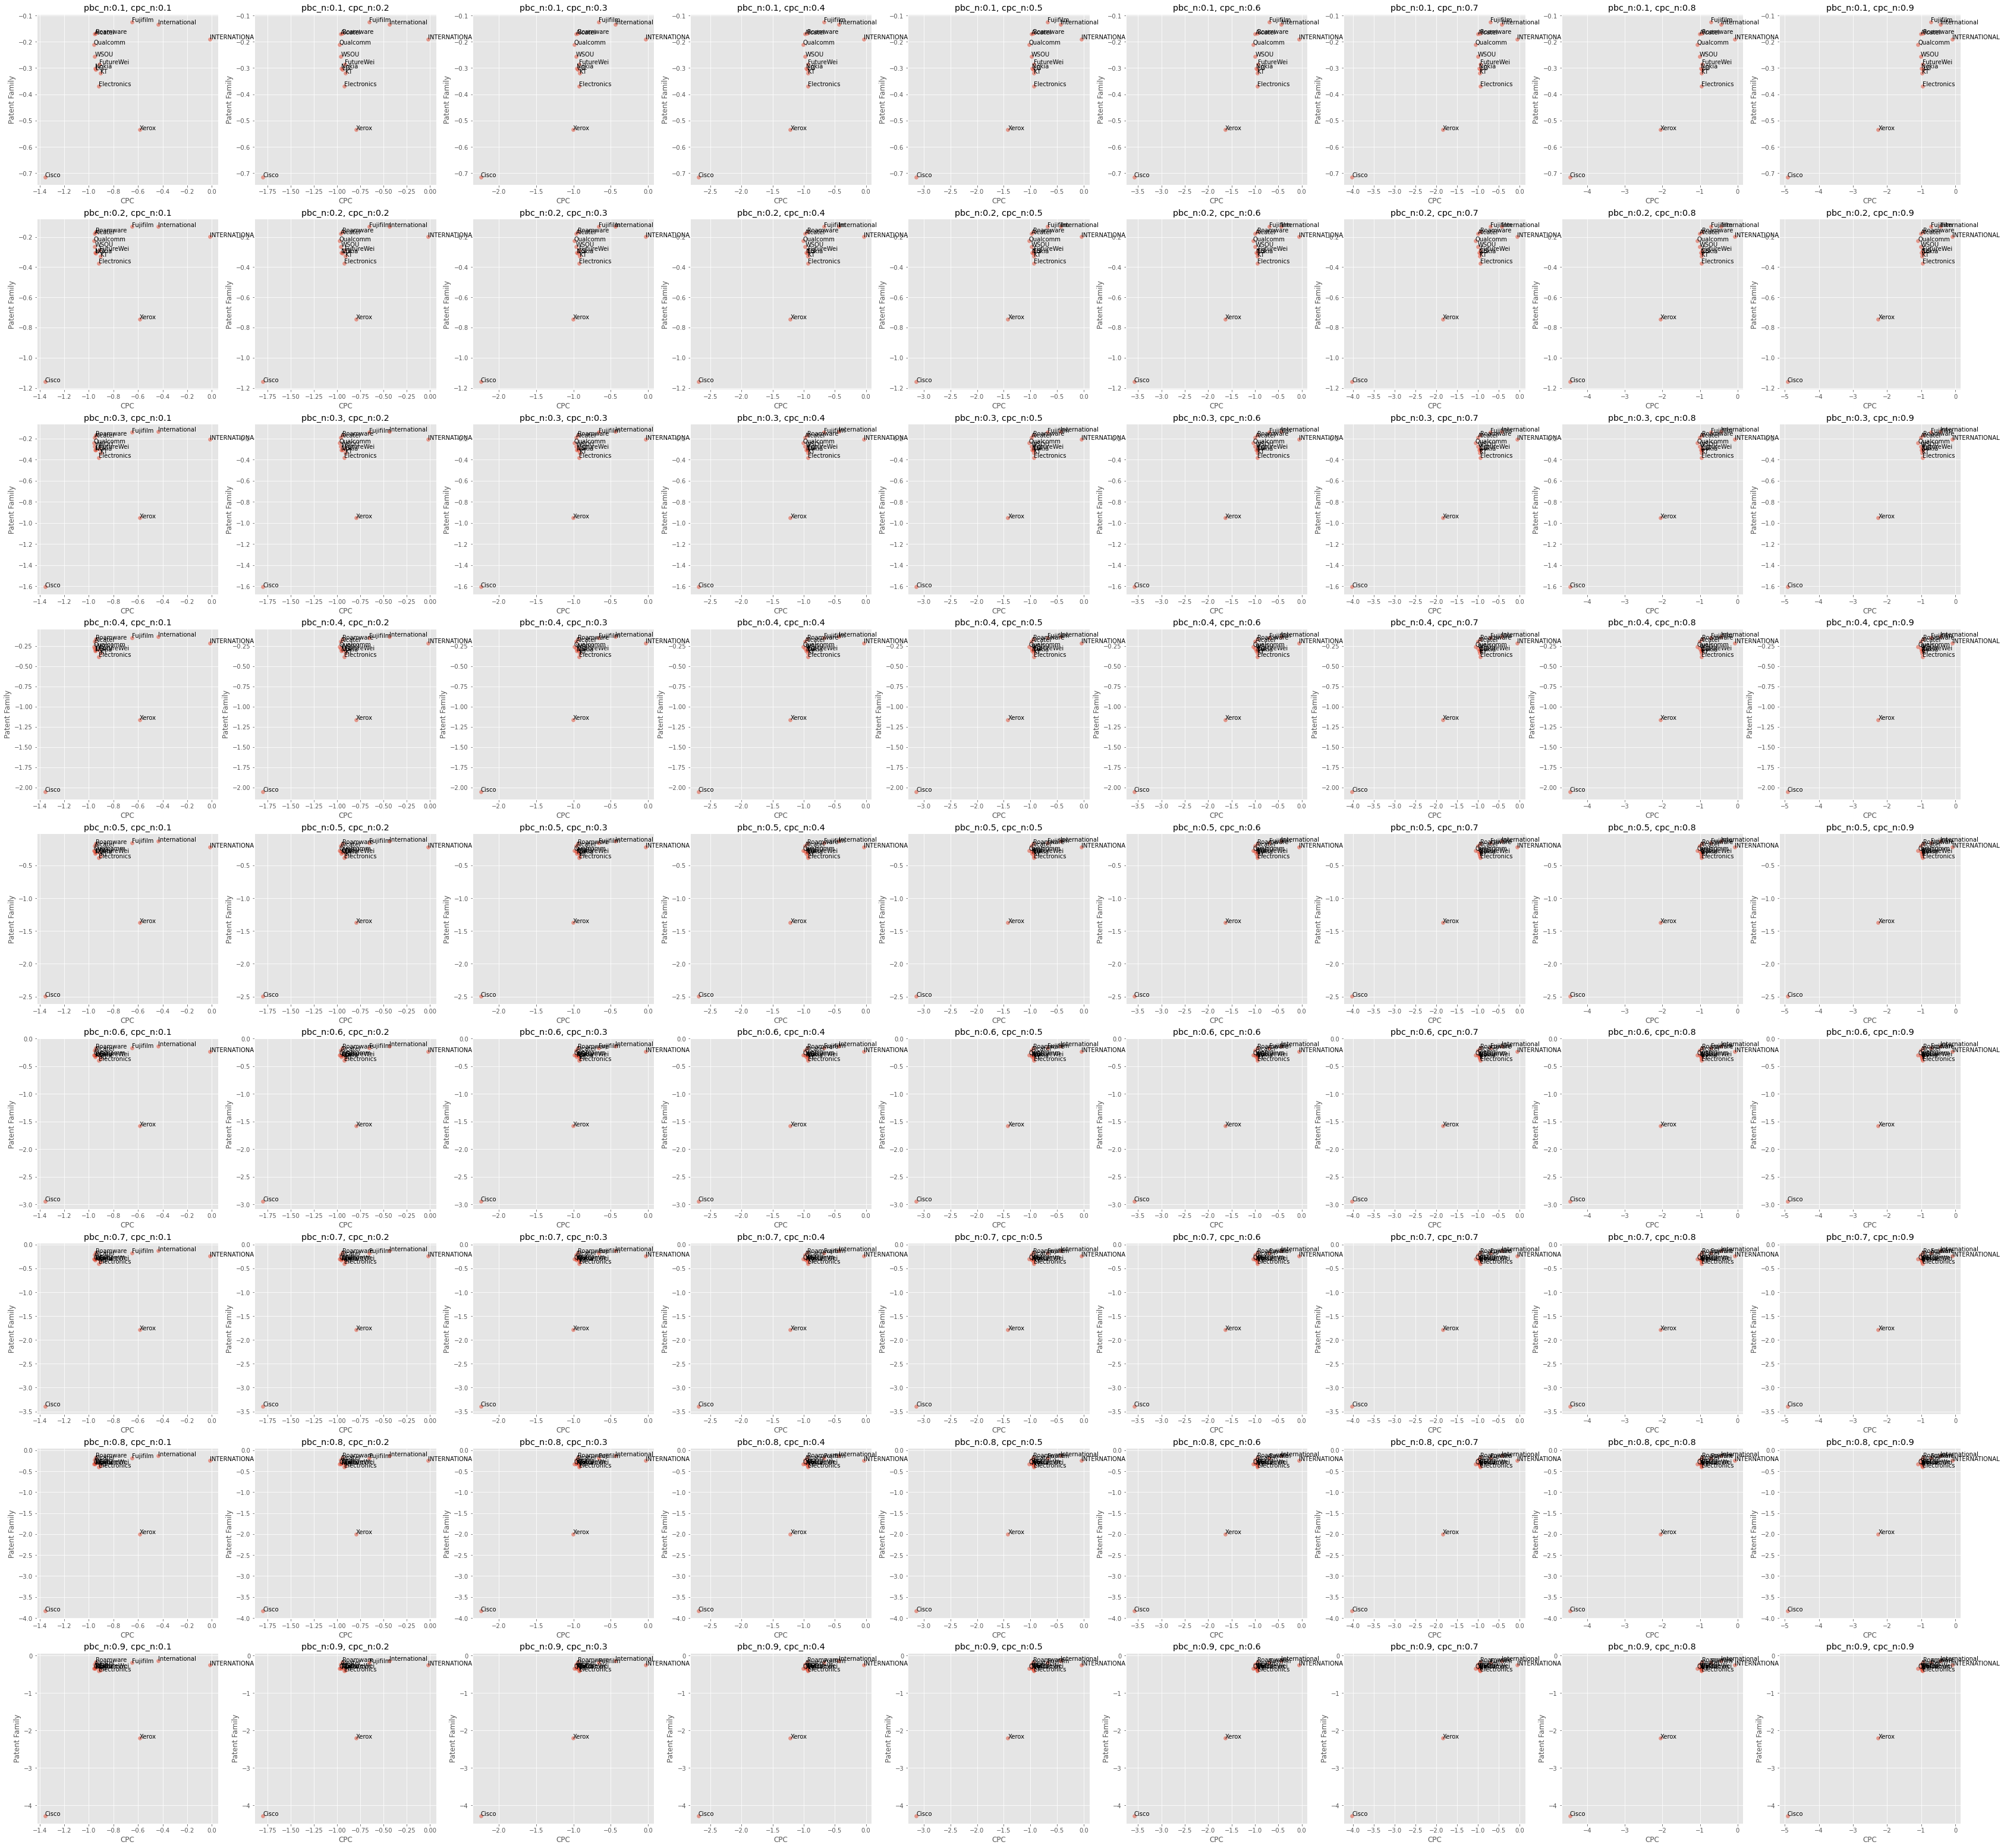

In [32]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_2012_1.png'.format(pbc_n))

In [33]:
c_df

,cpc,country
company,,
Cisco Technology Inc,4.917983,4.277121
Xerox Corp,2.261995,2.209576
Qualcomm Inc,1.092406,0.341144
Electronics and Telecommunications Research Institute ETRI,0.959629,0.408450
FutureWei Technologies Inc,0.955528,0.324035
Nokia Solutions and Networks Oy,0.989258,0.340268
LG Electronics Inc,0.944444,0.306818
International Business Machines Corp,0.435897,0.132867
Roamware Inc,0.944444,0.167832


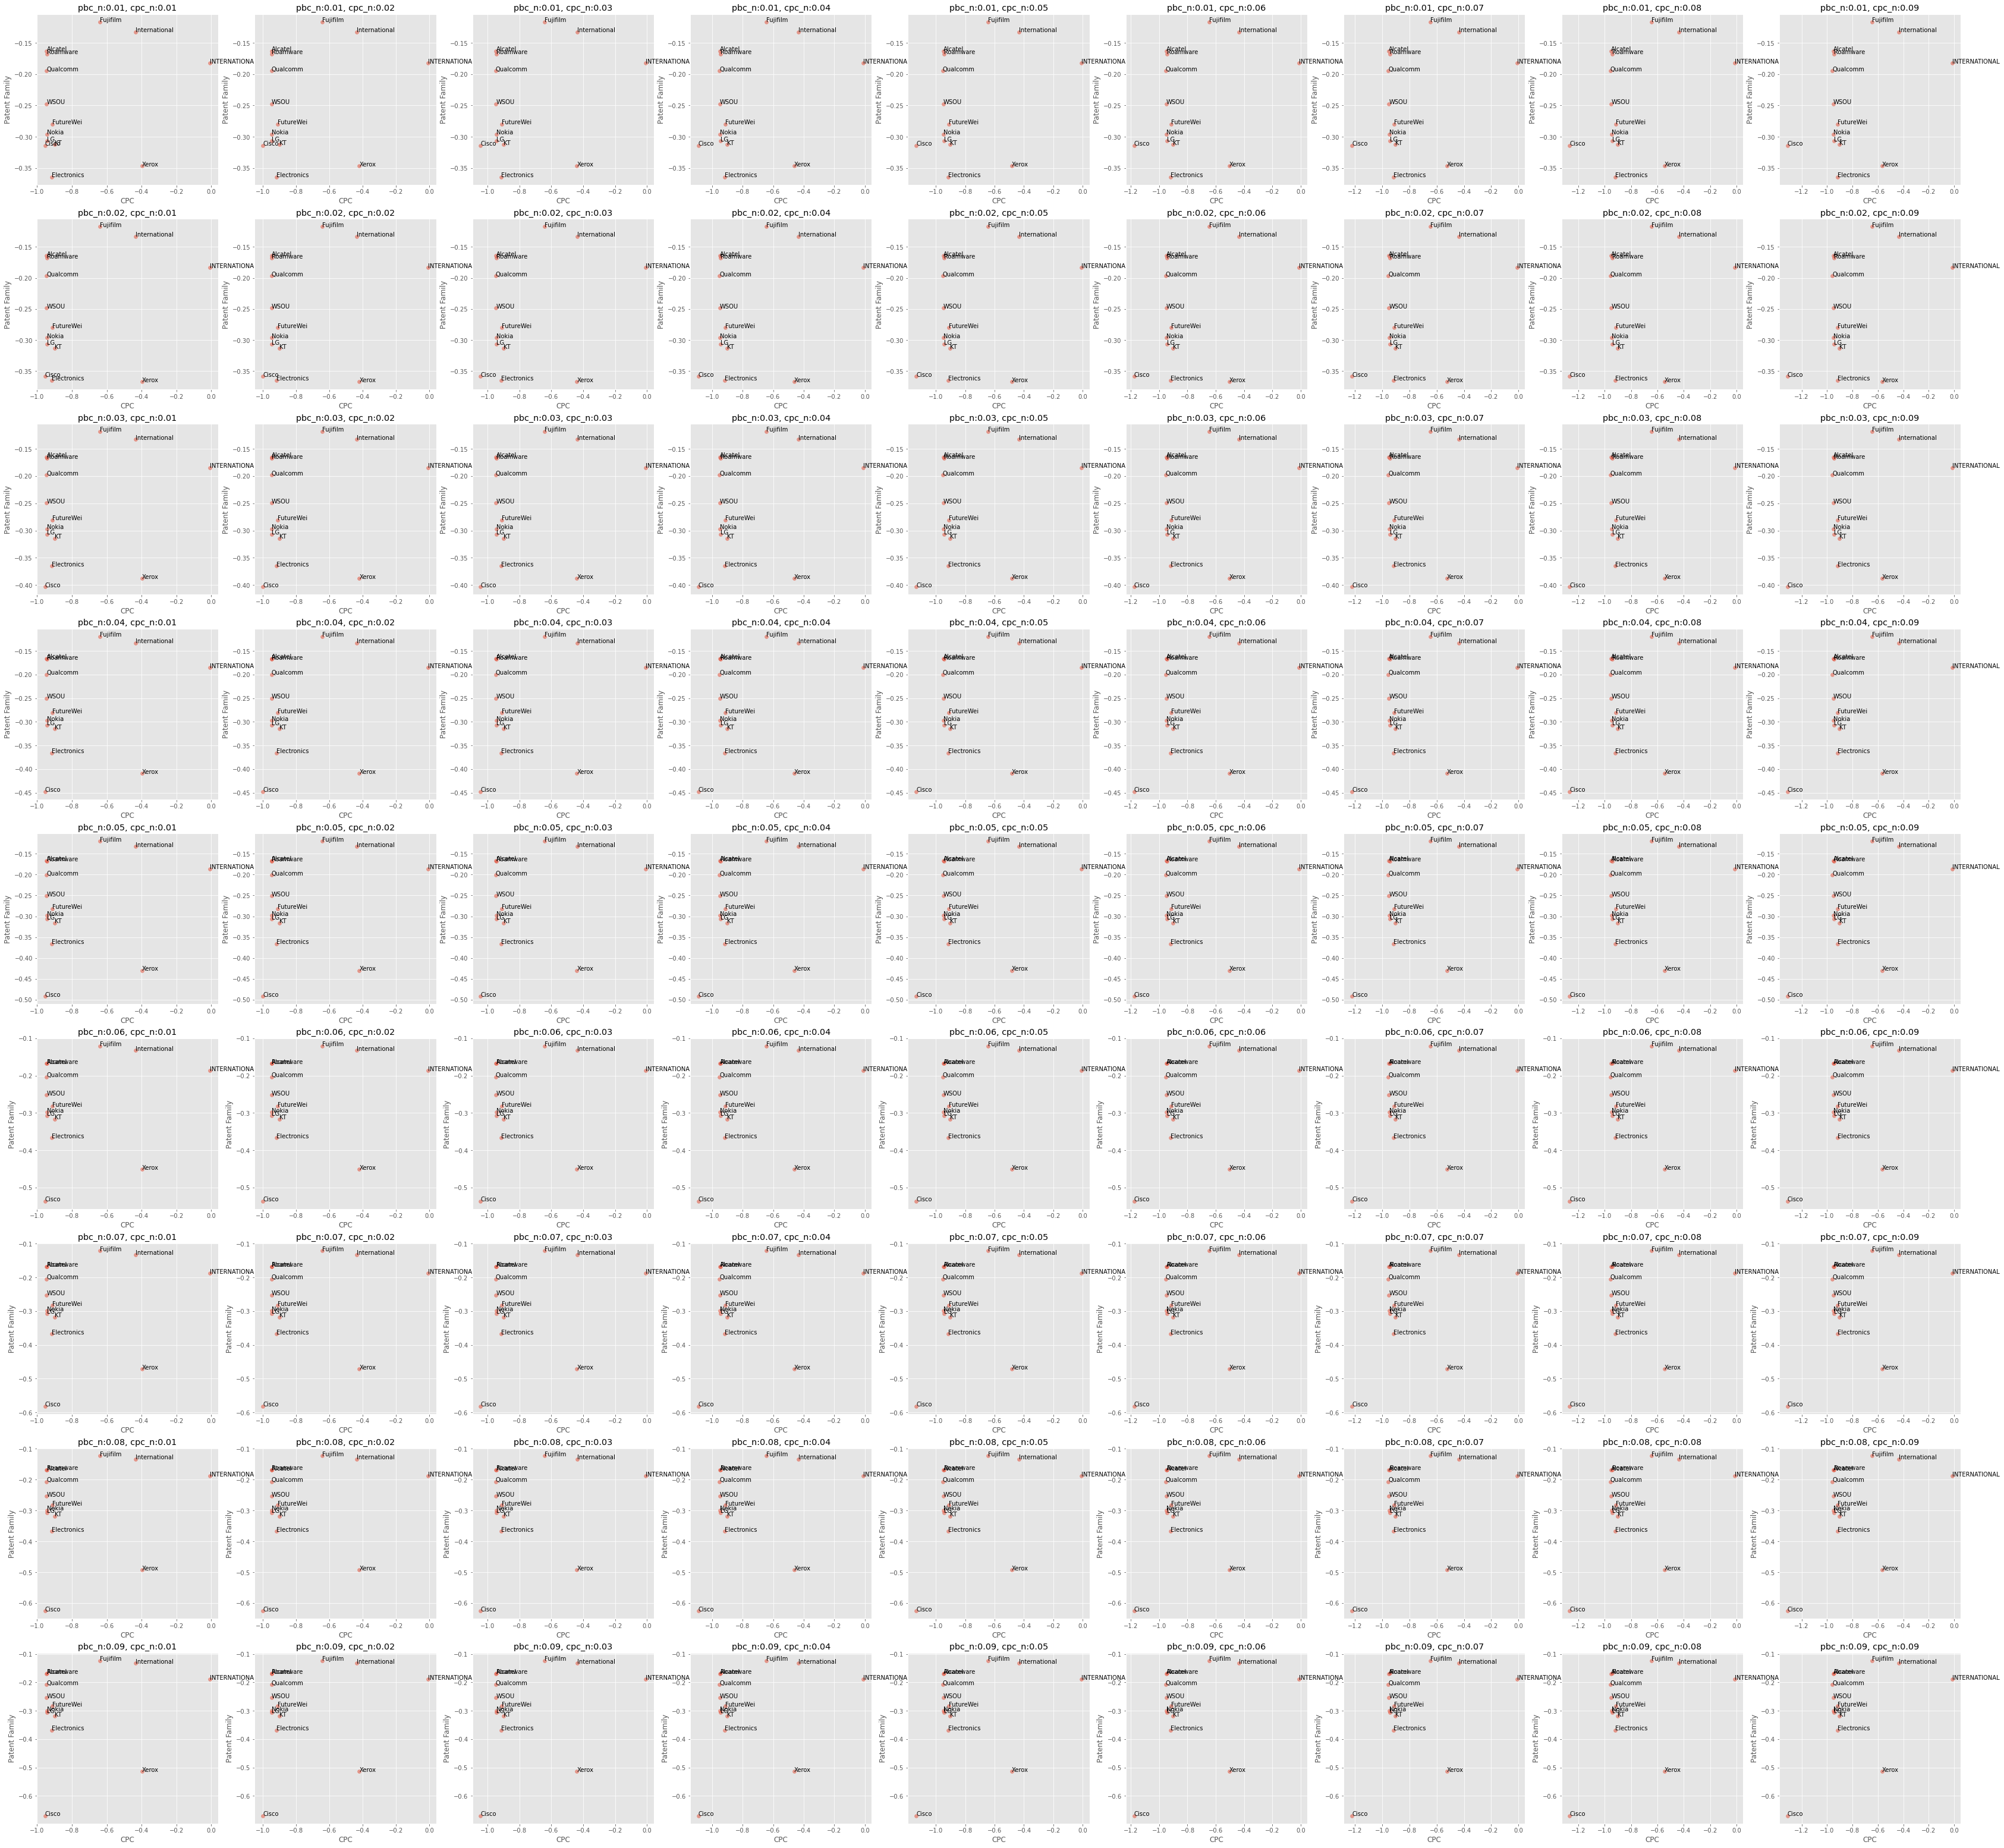

In [34]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_2012_2.png'.format(pbc_n))

In [35]:
c_df

,cpc,country
company,,
Cisco Technology Inc,1.311053,0.670191
Xerox Corp,0.566199,0.513781
Qualcomm Inc,0.959241,0.207978
Electronics and Telecommunications Research Institute ETRI,0.919296,0.368118
FutureWei Technologies Inc,0.915196,0.283702
Nokia Solutions and Networks Oy,0.948926,0.299936
LG Electronics Inc,0.944444,0.306818
International Business Machines Corp,0.435897,0.132867
Roamware Inc,0.944444,0.167832


### Scatter Plot2

In [36]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

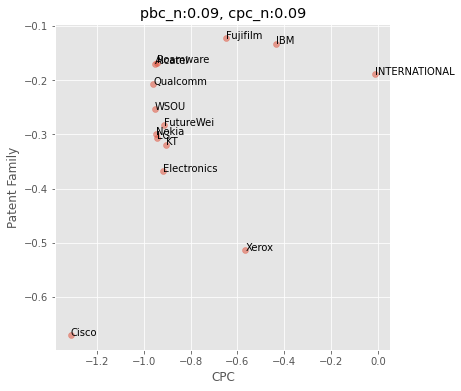

In [37]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [38]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [39]:
competitor_ls

[4, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1]

In [40]:
c_df

,cpc,country
company,,
Cisco Systems,1.311053,0.670191
Xerox,0.566199,0.513781
Qualcomm,0.959241,0.207978
Electronics and Telecommunications Research Institute ETRI,0.919296,0.368118
FutureWei Technologies,0.915196,0.283702
Nokia,0.948926,0.299936
LG Electronics,0.944444,0.306818
IBM,0.435897,0.132867
Roamware,0.944444,0.167832


## DE

In [41]:
ccontry = pd.read_csv("../rm_company_country_de_2012.csv")
ccpc = pd.read_csv("../rm_company_cpc_de_2012.csv")

In [ ]:
ccontry[ccontry.company.isin(com_de_ls)]

### Similarity計算

#### Country

- 換成機率  

In [ ]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

#### PBC
- 和Samsung Electronics Co Ltd比較

In [ ]:
ccontry_pbc = ccontry2.loc[com_de_ls,:].copy()
ccontry_pbc.head()

In [ ]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

#### CPC

In [ ]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [ ]:
ccpc_pbc = ccpc2.loc[com_de_ls,:].copy()
# ccpc_pbc

In [ ]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### Scatter Plot

In [ ]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_de_df.count_log[com_de_df.company=="Samsung Electronics Co Ltd"].values-com_de_df.count_log[com_de_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_de_df.count_log[com_de_df.company=="Samsung Electronics Co Ltd"].values-com_de_df.count_log[com_de_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

In [ ]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_de_2012_1.png'.format(pbc_n))

In [ ]:
c_df

In [ ]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_de_2012_2.png'.format(pbc_n))

In [ ]:
c_df

### Scatter Plot2

In [ ]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

In [ ]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [ ]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [ ]:
competitor_ls

In [ ]:
c_df